[home](http://www.brandonrose.org)

# Document Clustering with Python

In [1]:
# !pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master
# !pip install jupyter_nbextensions_configurator
# !jupyter contrib nbextension install --user
# !jupyter nbextensions_configurator enable --user

In [ ]:
# !pip install mpld3

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# Stopwords, stemming, and tokenizing 

In [10]:
texts = list(df['word'])
intents = list(df['intent'])
confidences = list(df['confidence'])

print(str(len(texts)) + ' texts')
print(str(len(intents)) + ' intents')
print(str(len(confidences)) + ' confidences')

1593 texts
1593 intents
1593 confidences


In [16]:
# load nltk's English stopwords as variable called 'stopwords'
# stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [17]:
# load nltk's SnowballStemmer as variabled 'stemmer'
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [18]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

# def tokenize_and_stem(text):
#     # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
#     tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#     filtered_tokens = []
#     # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
#     for token in tokens:
#         if re.search('[a-zA-Z]', token):
#             filtered_tokens.append(token)
#     stems = [stemmer.stem(t) for t in filtered_tokens]
#     return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [24]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for text in texts:
#     allwords_stemmed = tokenize_and_stem(text)
#     totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [25]:
# vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_tokenized)

## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=2000,
#                                    stop_words='english',
                                   use_idf=True, 
#                                    tokenizer=tokenize_and_stem, 
                                   tokenizer=tokenize_only, 
                                   ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

print(tfidf_matrix.shape)

CPU times: user 423 ms, sys: 2.79 ms, total: 425 ms
Wall time: 424 ms
(2072, 2000)


In [27]:
terms = tfidf_vectorizer.get_feature_names()

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [29]:
from sklearn.cluster import KMeans

num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 2.43 s, sys: 0 ns, total: 2.43 s
Wall time: 2.43 s


In [30]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [31]:
annotations = { 'text': texts, 'intent': intents, 'cluster': clusters, 'confidence': confidences}

In [32]:
frame = pd.DataFrame(annotations, index = [clusters] , columns = ['text', 'cluster', 'intent', 'confidence'])

In [33]:
frame.head()

,text,cluster,intent,confidence
3,thank you so much thank you thank,3,agent-politeness,0.990885
2,thank you very much appreciate,2,agent-politeness,0.988797
3,very good thank you so much,3,agent-politeness,0.982222
2,thank thank you very much sure.,2,agent-politeness,0.980986
0,thank you really appreciate what you did.,0,agent-politeness,0.980430


In [34]:
frame['cluster'].value_counts()

0    1571
2     246
1     154
3     101
Name: cluster, dtype: int64

In [35]:
grouped = frame['confidence'].groupby(frame['cluster'])
grouped.mean()

cluster
0    0.813613
1    0.810218
2    0.854889
3    0.848657
Name: confidence, dtype: float64

In [36]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d texts:" % i, end='')
    for text in frame.ix[i]['text'].values.tolist():
        print(' %s\n' % text, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'you', b'i', b'that', b'do', b'can', b'me',

Cluster 0 texts: thank you really appreciate what you did.
 'cause that'd be thank you
 thank you i really appreciate it.
 are you sure would thank you?
 you're welcome and thank you
 thank you appreciate that.
 thank you have a wonderful
 you been very helpful thank you appreciate.
 our costs to our copyright copyrighted
 i'm doing great thank you.
 i appreciate it thank you again.
 okay thank you let me check me too okay ma'am are you there
 you are so helpful thank you.
 i thank you have a great day
 you understand you're welcome am
 thank you happen to you too
 thank you have agree there.
 okay thank think you're much.
 are you sure you don't wanna
 on they'll tell you are very helpful thank you.
 thank you have a great day
 already appreciate that thank you.
 i really am not thank you anyway.
 understand that thank you.
 thank you and see see you a
 oh let me see what i can find here
 i really a

/home/ec2-user/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/home/ec2-user/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


 b'can',

Cluster 1 texts: thank you very much is there anything else that i can help
 thank you very much anything else i can help you with.
 this maybe something here that i can help you okay.
 thank you anything else i can help you with today.
 anything else i can help you
 else that i know you're very welcome anything else that i can help you with.
 very think think you very much is there anything else i may help you with today.
 you're welcome anything else i can help you with today me, so i can
 thank you is there anything else i can help you with today.
 and you're welcome anything else i can help you with
 well, thank you very much is there anything else i can help you with?
 you're welcome is there anything else that i can help you with
 is there anything else i can help you
 you're welcome anything else i can help you with today me surprise.
 you're very welcome sir, anything else that i can do for you.
 you're welcome anything else i can help you with today.
 you're welcome 

# Multidimensional scaling

In [37]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [38]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [39]:
#set up colors per clusters using a dict
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a',
#                   4: '#66a61e', 5: '#960000', 6: '#96fffa', 7: '#190000', 8: '#9632fa', 9: '#963214'
                 }

#set up cluster names using a dict
cluster_names = {i: f'Cluster {i}' for i in range(len(cluster_colors))}

In [40]:
intent_and_text = [': '.join(t) for t in list(zip(intents, texts))]
intent_and_text[1]

'agent-politeness: thank you very much appreciate'

/home/ec2-user/venv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ec2-user/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


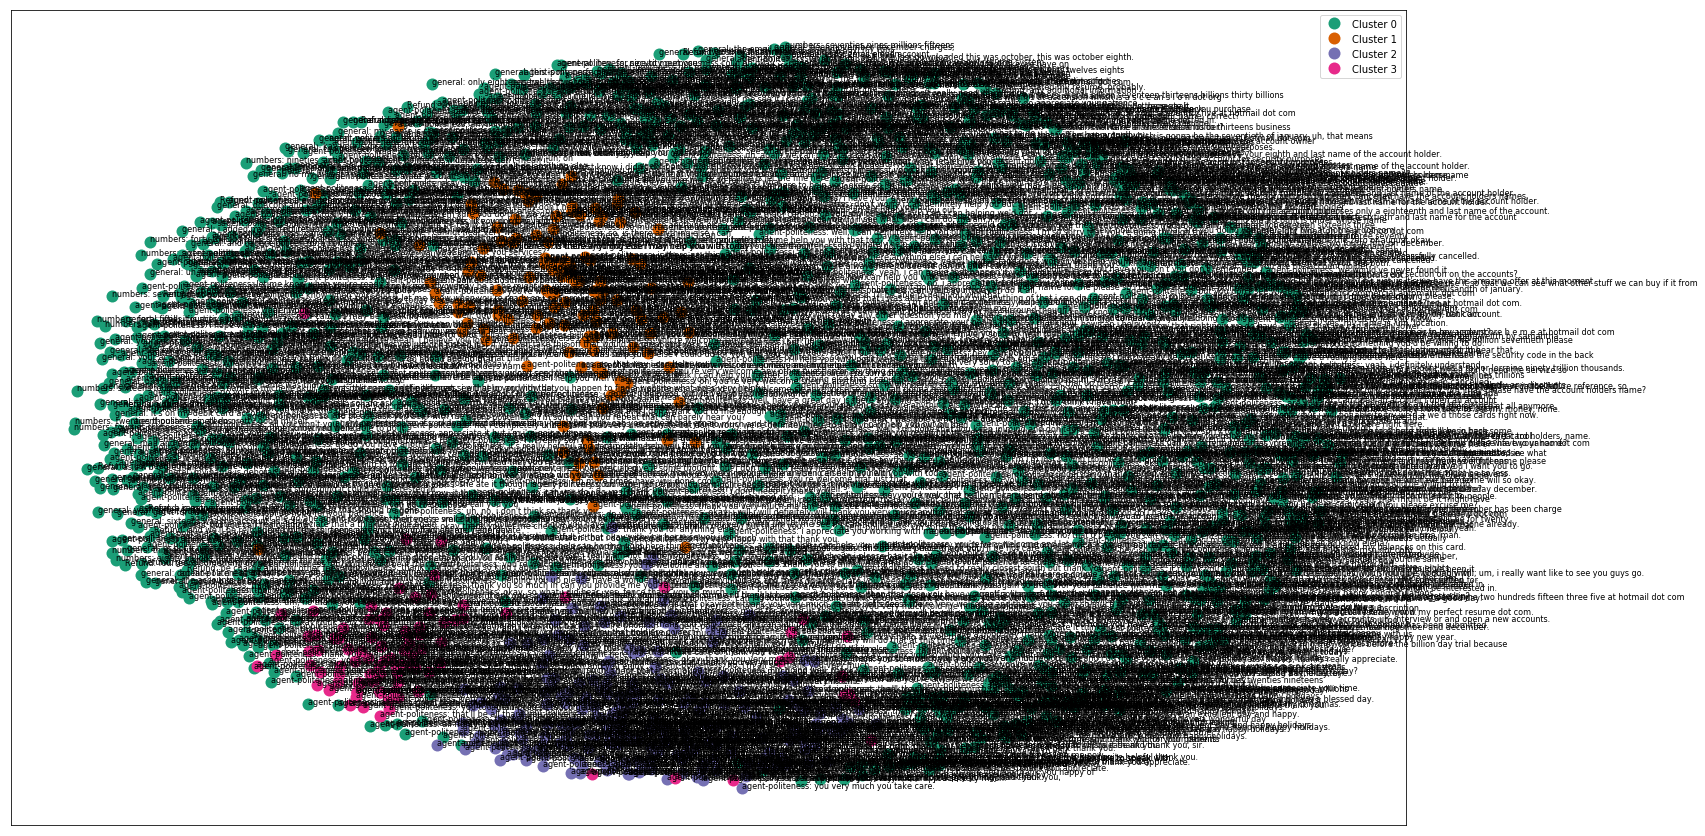

In [41]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=intent_and_text))

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(25, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the 
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)

plt.show() #show the plot

#uncomment the below to save the plot if need be
# plt.savefig('clusters_small_noaxes.png', dpi=200)

In [42]:
plt.close()

[mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [43]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=intent_and_text)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(28,20)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot
mpld3.enable_notebook()
mpld3.show() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


# Hierarchical document clustering

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=intents);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
plt.close()

# Latent Dirichlet Allocation

In [ ]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [ ]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [ ]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in texts]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [ ]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

In [ ]:
dictionary = corpora.Dictionary(texts)

In [ ]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
len(corpus)

In [ ]:
%time lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [ ]:
print(lda[corpus[0]])

In [ ]:
topics = lda.print_topics(5, num_words=20)

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [ ]:
topics_matrix